In [1]:
import mynn as nn
from draw_tools.plot import plot

import numpy as np
from struct import unpack
import gzip
import matplotlib.pyplot as plt
import pickle

# fixed seed for experiment
np.random.seed(309)

train_images_path = r'.\dataset\MNIST\train-images-idx3-ubyte.gz'
train_labels_path = r'.\dataset\MNIST\train-labels-idx1-ubyte.gz'

with gzip.open(train_images_path, 'rb') as f:
        magic, num, rows, cols = unpack('>4I', f.read(16))
        train_imgs=np.frombuffer(f.read(), dtype=np.uint8).reshape(num, 28*28)
    
with gzip.open(train_labels_path, 'rb') as f:
        magic, num = unpack('>2I', f.read(8))
        train_labs = np.frombuffer(f.read(), dtype=np.uint8)


# choose 10000 samples from train set as validation set.
idx = np.random.permutation(np.arange(num))
# save the index.
with open('idx.pickle', 'wb') as f:
        pickle.dump(idx, f)
train_imgs = train_imgs[idx]
train_labs = train_labs[idx]
valid_imgs = train_imgs[:10000]
valid_labs = train_labs[:10000]
train_imgs = train_imgs[10000:]
train_labs = train_labs[10000:]

# normalize from [0, 255] to [0, 1]
train_imgs = train_imgs / train_imgs.max()
valid_imgs = valid_imgs / valid_imgs.max()

# 在现有预处理基础上增加维度扩展
train_imgs = train_imgs.reshape(-1, 1, 28, 28)  # 转换为[N, C, H, W]格式
valid_imgs = valid_imgs.reshape(-1, 1, 28, 28)
    

In [2]:
def train_model(conv_configs,fc_configs,use_global_avg_pool,lr,epochs,save_dir, patience=10):
    # 初始化CNN模型
    model = nn.models.Model_CNN(
        conv_configs=conv_configs,
        fc_configs=fc_configs,
        act_func='ReLU',
        use_global_avg_pool=use_global_avg_pool
    )
    
    opt = nn.optimizer.MomentGD(init_lr=lr,model=model,mu=0.9)
    scheduler = nn.lr_scheduler.MultiStepLR(opt, milestones=[7500, 75000], gamma=0.5)
    loss_fn = nn.op.MultiCrossEntropyLoss(model=model)
    metric = nn.metric.accuracy
    
    trainer = nn.runner.RunnerM(
        model=model,
        optimizer=opt,
        metric=metric,
        loss_fn=loss_fn,
        batch_size=64,
        scheduler=scheduler
    )

    trainer.train(
        train_set=(train_imgs, train_labs),
        dev_set=(valid_imgs, valid_labs),
        num_epochs=epochs,
        log_epochs=1,  # 每1个epoch打印一次日志
        save_dir=save_dir,
        patience=patience  # 传递早停参数
    )


    # 绘制训练曲线
    _, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].plot(trainer.train_loss, label='Train Loss')
    axes[0].plot(trainer.dev_loss, label='Val Loss')
    axes[0].set_title('Loss Curve')
    axes[0].legend()
    
    axes[1].plot(trainer.train_scores, label='Train Acc')
    axes[1].plot(trainer.dev_scores, label='Val Acc')
    axes[1].set_title('Accuracy Curve')
    axes[1].legend()
    
    plt.show()
    
    return trainer

/saved_models/cnn_model

Epoch: 1/100
[Train] Loss: 2.8904, Score: 0.5573
[Dev]   Loss: 1.2115, Score: 0.6457

Epoch: 2/100
[Train] Loss: 0.9502, Score: 0.7260
[Dev]   Loss: 0.7730, Score: 0.7673

Epoch: 3/100
[Train] Loss: 0.6694, Score: 0.8021
[Dev]   Loss: 0.6215, Score: 0.8084

Epoch: 4/100
[Train] Loss: 0.5331, Score: 0.8429
[Dev]   Loss: 0.4825, Score: 0.8585

Epoch: 5/100
[Train] Loss: 0.4439, Score: 0.8679
[Dev]   Loss: 0.4347, Score: 0.8677

Epoch: 6/100
[Train] Loss: 0.3839, Score: 0.8834
[Dev]   Loss: 0.3722, Score: 0.8919

Epoch: 7/100
[Train] Loss: 0.3348, Score: 0.9002
[Dev]   Loss: 0.3223, Score: 0.9048

Epoch: 8/100
[Train] Loss: 0.2976, Score: 0.9109
[Dev]   Loss: 0.2996, Score: 0.9140

Epoch: 9/100
[Train] Loss: 0.2696, Score: 0.9193
[Dev]   Loss: 0.2605, Score: 0.9231

Epoch: 10/100
[Train] Loss: 0.2449, Score: 0.9270
[Dev]   Loss: 0.2461, Score: 0.9277

Epoch: 11/100
[Train] Loss: 0.2290, Score: 0.9309
[Dev]   Loss: 0.2338, Score: 0.9314

Epoch: 12/100
[Train] Loss: 0.2203, Score: 0.9338
[D

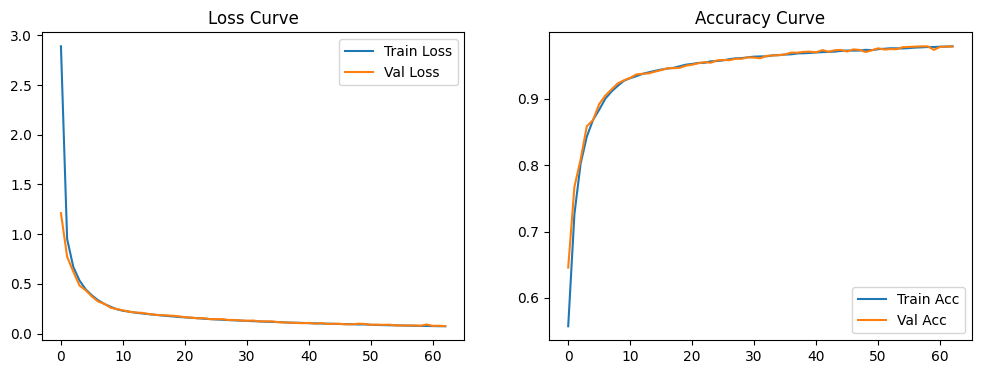

In [3]:
conv_configs = [
    {
        'type': 'conv',
        'in_channels': 1,          # MNIST灰度图通道数
        'out_channels': 16,       
        'kernel_size': 5,
        'stride': 1,
        'padding': 0,
        'weight_decay': True,      # 可选：添加正则化
        'weight_decay_lambda': 1e-4
    },
    {
        'type': 'pool',
        'pool_type': 'avg',
        'kernel_size': 2,
        'stride': 2
    },
    {
        'type': 'conv',
        'in_channels': 16,          # MNIST灰度图通道数
        'out_channels': 32,       
        'kernel_size': 5,
        'stride': 1,
        'padding': 0,
        'weight_decay': True,      # 可选：添加正则化
        'weight_decay_lambda': 1e-4
    },
    {
        'type': 'pool',
        'pool_type': 'avg',
        'kernel_size': 2,
        'stride': 2
    }
]

fc_configs = [
    (512, 10)  
]


trainer_0 = train_model(conv_configs, fc_configs, False, 0.1, 100, f'./saved_models/cnn_model', patience=5)